# Homework 7
### Benjamin Tollison
I am a firm beliver that your code should be readible on it's own without comments,avoid single letter variables because LSP's exist, and you should never go beyond 2 nests to maintain readablity. Since the assignment has asked for comments to explain what is happening, I will use markdown and include my derivation of equations in the markdown.

This first block of code is just a header that I use for all of my assignments because print statements should only be used for troubleshooting.(and for outputting latex to easily put into assignments)

In [1]:
### Benjamin Tollison ###

from decimal import Decimal

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import sympy as sp
from IPython.display import Latex, Math, display
from sympy import (
    Eq,
    Function,
    Matrix,
    cos,
    cosh,
    exp,
    integrate,
    lambdify,
    pi,
    sin,
    sinh,
    symbols,
)
from sympy.solvers.pde import pdsolve
from sympy.solvers.solveset import linsolve


def displayEquations(LHS,RHS):
    left = sp.latex(LHS)
    right = sp.latex(RHS)
    display(Math(left + '=' + right))
    np.set_printoptions(suppress=True)
def displayVariable(variable:str,RHS):
    left = sp.latex(symbols(variable))
    right = sp.latex(RHS)
    display(Math(left + '=' + right))
def displayVariableWithUnits(variable:str,RHS,units):
    left = sp.latex(symbols(variable))
    right = sp.latex(RHS)
    latexUnit = sp.latex(symbols(units))
    display(Math(left + '=' + right + '\\;' +'\\left['+ latexUnit + '\\right]'))
def format_scientific(number:float):
    a = '%E' % number
    return a.split('E')[0].rstrip('0').rstrip('.') + 'E' + a.split('E')[1]
deg2rad = np.pi/180
rad2deg = 180/np.pi

### Question 1
As a note for notation wise:\
I use Area defined as $\sigma$ to stay consistent with 351 Cizmas.\
Setting the given equation to the definition of the critical area ratio in the book
$$\frac{\sigma}{\sigma_{cr}} = 
\frac{8-4\cos(\pi x)}{4} = 
\frac{1}{M} \left[\frac{2}{\gamma+1}\left(1+\frac{\gamma-1}{2}M^2\right)^\frac{\gamma+1}{2(\gamma-1)}\right]$$
Knowing that $\gamma = 1.4$ and that $-0.25<x<1$ we can us Householder's second order root method from the nasa report:\
https://www.grc.nasa.gov/www/winddocs/utilities/b4wind_guide/mach.html
$$ x_{i+1} = x_i - \frac{2f}{f'-\sqrt{f'^2-ff''}}$$
With the subsonic regime being defined by:
$$f = (P+QX)^\frac{1}{Q} - RX = 0$$
$$f' = (P+QX)^{\frac{1}{Q}-1} - R$$
$$f'' = P(P+QX)^{\frac{1}{Q}-2}$$
and the supersonic regime can be found with the following:
$$f = (PX+Q)^\frac{1}{P} - RX = 0$$
$$f' = (PX+Q)^{\frac{1}{P}-1} - R$$
$$f'' = Q(PX+Q)^{\frac{1}{P}-2}$$
And the Coefficients can be defined by:
$$P=\frac{2}{\gamma+1}$$
$$Q = \frac{\gamma-1}{\gamma+1}=1-P $$
$$X_{sub} = M^2$$
$$X_{super} = \frac{1}{M^2}$$
$$R = \left(\frac{\sigma}{\sigma_{cr}}\right)^2$$
Therefore we can have 4 possible solutions. Subsonic->subsonic, subsonic->supersonic, supersonic->subsonic, or supersonic->supersonic

In [2]:
def HouseholdP2(x_intial,scheme_function,scheme_prime,scheme_double_prime):
  max_iterations = 1000
  while abs(scheme_function(x_intial)) > 1e-8:
    x_intial = x_intial - ((2*scheme_function(x_intial))/(scheme_prime(x_intial) - (scheme_prime(x_intial)**2-scheme_function(x_intial)*scheme_double_prime(x_intial))**0.5))
    max_iterations -=1
    if max_iterations ==0:
      print('The scheme didn\'t converge')
      break
  return x_intial
def HouseholdTunnelMach(x_position:float,section_supersonic:bool)->float:
  P = 2/2.4
  Q = 1-P
  R = (2-np.cos(np.pi*x_position))**2
  x_intial = 0.001
  if section_supersonic==False:
    f = lambda X : (P+Q*X)**(1/Q) - R*X
    f_prime = lambda X: (P+Q*X)**((1/Q)-1) - R
    f_double_prime = lambda X: P*(P+Q*X)**((1/Q)-2)
    x_final = HouseholdP2(x_intial,f,f_prime,f_double_prime)
    return (x_final)**0.5
  if section_supersonic == True: 
    f = lambda X : (P*X+Q)**(1/P) - R*X
    f_prime = lambda X: (P*X+Q)**((1/P)-1) - R
    f_double_prime = lambda X: Q*(P*X+Q)**((1/P)-2)
    x_final = abs(HouseholdP2(x_intial,f,f_prime,f_double_prime))
    return 1/(x_final)**0.5
mach_values = {'sub2sub':[],'sub2sup':[],'sup2sub':[],'sup2sup':[]}
x_values_section_1 = np.linspace(-0.25,0,500)
x_values_section_2 = np.linspace(0,1,500)
mach_values['sub2sub'] = [HouseholdTunnelMach(x,False)for x in x_values_section_1]+[HouseholdTunnelMach(x,False)for x in x_values_section_2]
mach_values['sub2sup'] = [HouseholdTunnelMach(x,False)for x in x_values_section_1] + [HouseholdTunnelMach(x,True)for x in x_values_section_2]
mach_values['sup2sub'] = [HouseholdTunnelMach(x,True)for x in x_values_section_1] + [HouseholdTunnelMach(x,False)for x in x_values_section_2]
mach_values['sup2sup'] = [HouseholdTunnelMach(x,True)for x in x_values_section_1] + [HouseholdTunnelMach(x,True)for x in x_values_section_2]

,sub2sub,sub2sup,sup2sub,sup2sup
0,0.526140,0.526140,2.833221,2.833221
1,0.526801,0.526801,2.828701,2.828701
2,0.527464,0.527464,2.824184,2.824184
3,0.528128,0.528128,2.819670,2.819670
4,0.528792,0.528792,2.815159,2.815159
...,...,...,...,...
995,0.197471,8.438876,0.197471,8.438876
996,0.197461,8.439300,0.197461,8.439300
997,0.197454,8.439603,0.197454,8.439603
998,0.197450,8.439784,0.197450,8.439784


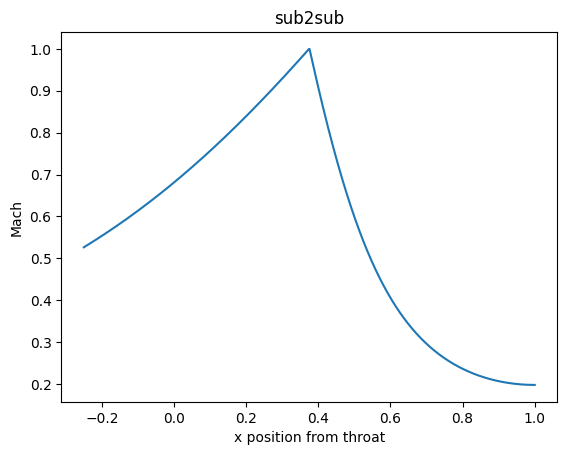

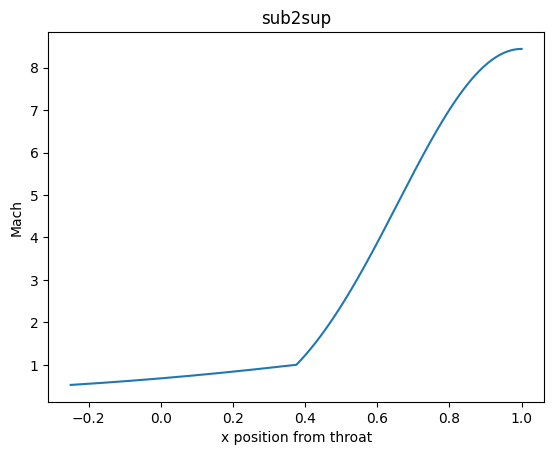

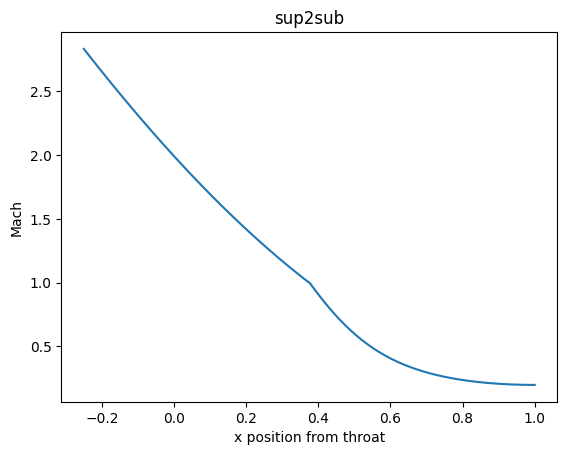

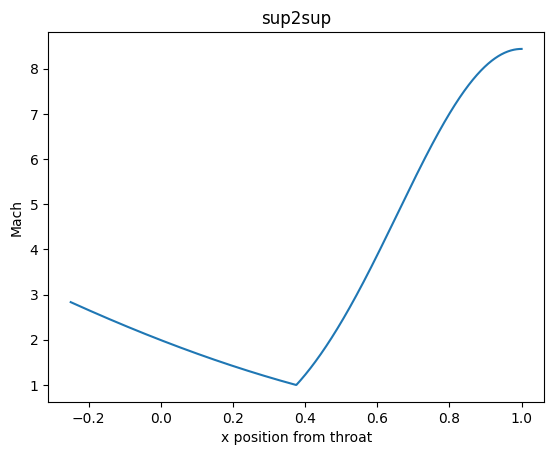

In [15]:
pd.DataFrame.from_dict(mach_values).to_csv('Mach-Tunnel.csv')
display(pd.DataFrame.from_dict(mach_values))
situations = list(mach_values.keys())
for i in situations:
  plt.plot(np.linspace(-0.25,1,1000),mach_values[i],label=i)
  plt.title(i)
  plt.xlabel('x position from throat')
  plt.ylabel('Mach')
  plt.show()